## Data Understanding & Preprocessing

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn shap ipywidgets --quiet

In [5]:
# Imports for preprocessing and models
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Loading the Dataset

In [7]:
from ucimlrepo import fetch_ucirepo

In [9]:
# Fetch dataset from UCI ML repo
breast_cancer = fetch_ucirepo(id=17)

# Extract features and target
X = breast_cancer.data.features
y = breast_cancer.data.targets

#### Data Exploration

In [11]:
# Display metadata and variable details
print(breast_cancer.metadata)
print(breast_cancer.variables)

# Check the first few rows
print(X.head())
print(y.head())

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

#### Data Preparation

In [13]:
#Combine into a single DataFrame (optional but convenient)
df = X.copy()
df['diagnosis'] = y

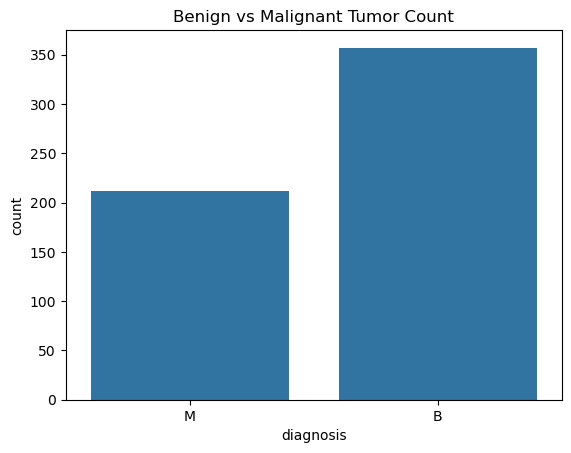

In [15]:
#Check class distribution
sns.countplot(x='diagnosis', data=df)
plt.title('Benign vs Malignant Tumor Count')
plt.savefig("Target_Distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
from sklearn.preprocessing import LabelEncoder

In [19]:
#Label Encoding (if not already numeric)
# Check diagnosis values
print(df['diagnosis'].unique())

# Encode 'diagnosis' if needed (e.g., if still B/M)
if df['diagnosis'].dtype == 'object':
    le = LabelEncoder()
    df['diagnosis'] = le.fit_transform(df['diagnosis'])  # M=1, B=0

['M' 'B']


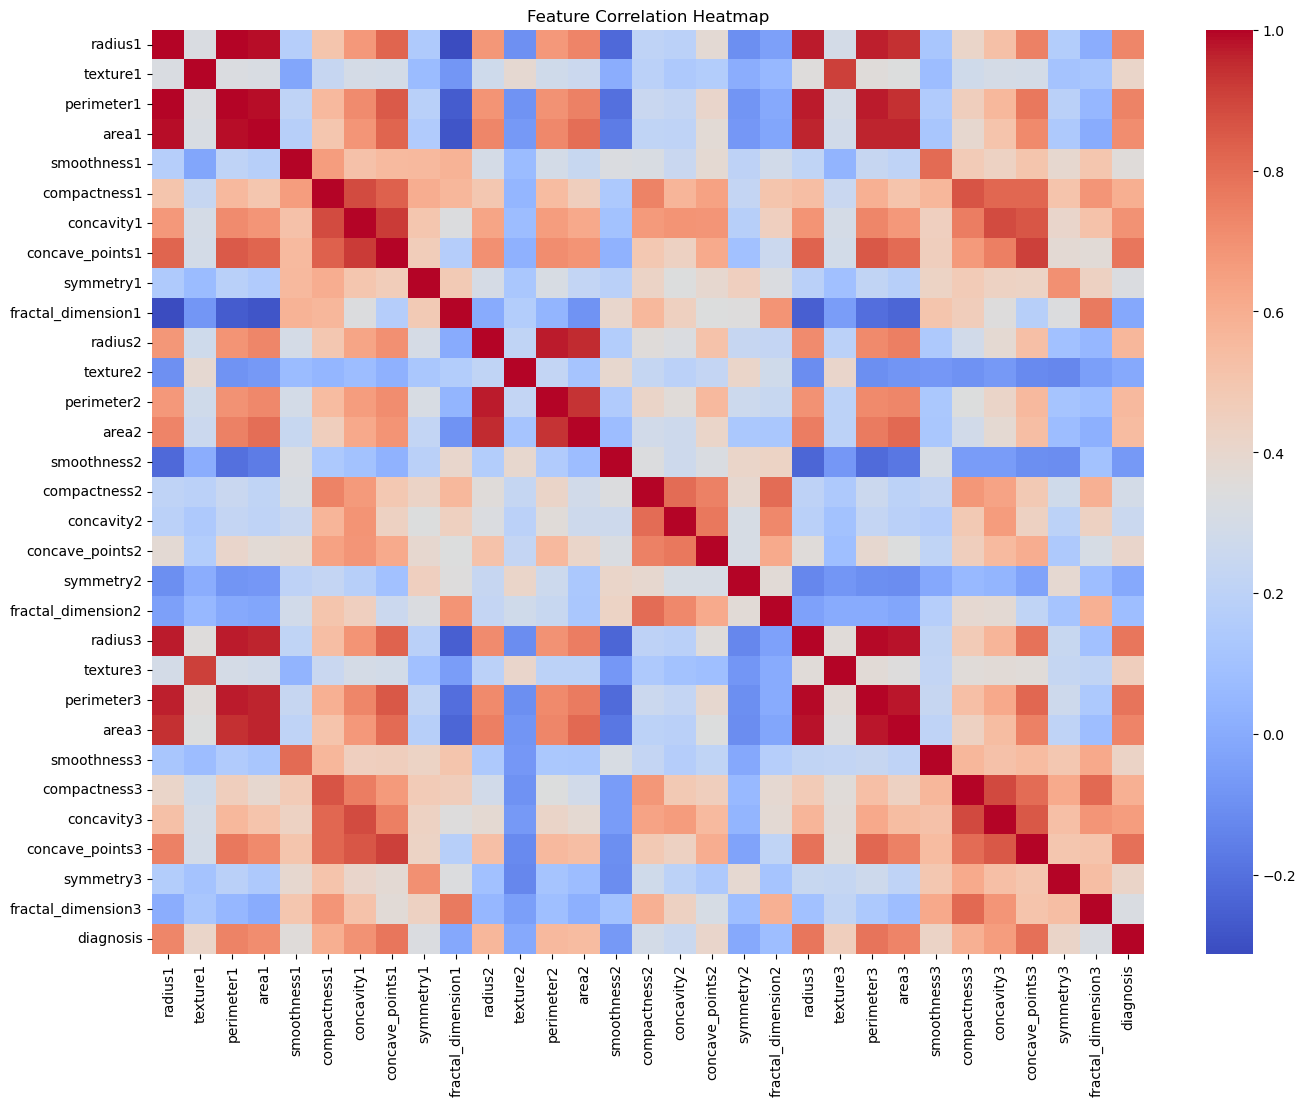

In [21]:
#Correlation Matrix
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

###### Preprocessing

In [23]:
#Split features and target
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

In [25]:
#Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

## Baseline Modeling

#### Setup

In [29]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#### Define Models

In [31]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

#### Define Metrics

In [33]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#### Evaluate Models

In [35]:
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv, scoring=scoring, return_train_score=False
    )
    
    results[name] = {
        metric: {
            'mean': np.mean(cv_results[f'test_{metric}']),
            'std': np.std(cv_results[f'test_{metric}'])
        }
        for metric in scoring
    }

Training Logistic Regression...
Training Random Forest...
Training Support Vector Machine...
Training K-Nearest Neighbors...
Training Gradient Boosting...
Training Naive Bayes...


#### Display Results in Table

In [37]:
results_df = pd.DataFrame({
    model: {
        metric: f"{vals['mean']*100:.2f}% ± {vals['std']*100:.2f}%"
        for metric, vals in metrics.items()
    }
    for model, metrics in results.items()
}).T

print(results_df)

                              accuracy       precision          recall  \
Logistic Regression     97.36% ± 1.49%  97.71% ± 2.80%  95.29% ± 3.99%   
Random Forest           96.48% ± 1.46%  96.41% ± 1.07%  94.12% ± 4.16%   
Support Vector Machine  97.14% ± 0.54%  97.69% ± 2.10%  94.71% ± 3.43%   
K-Nearest Neighbors     96.70% ± 1.55%  99.35% ± 1.29%  91.76% ± 3.43%   
Gradient Boosting       96.70% ± 1.39%  96.46% ± 2.11%  94.71% ± 3.43%   
Naive Bayes             93.85% ± 2.56%  92.47% ± 4.61%  91.18% ± 4.92%   

                                    f1         roc_auc  
Logistic Regression     96.40% ± 2.07%  99.58% ± 0.47%  
Random Forest           95.19% ± 2.07%  98.89% ± 0.67%  
Support Vector Machine  96.10% ± 0.82%  99.49% ± 0.47%  
K-Nearest Neighbors     95.38% ± 2.21%  98.70% ± 1.37%  
Gradient Boosting       95.53% ± 1.96%  99.07% ± 0.55%  
Naive Bayes             91.70% ± 3.42%  98.70% ± 0.71%  


#### Bar Plot for Accuracy & F1 Score

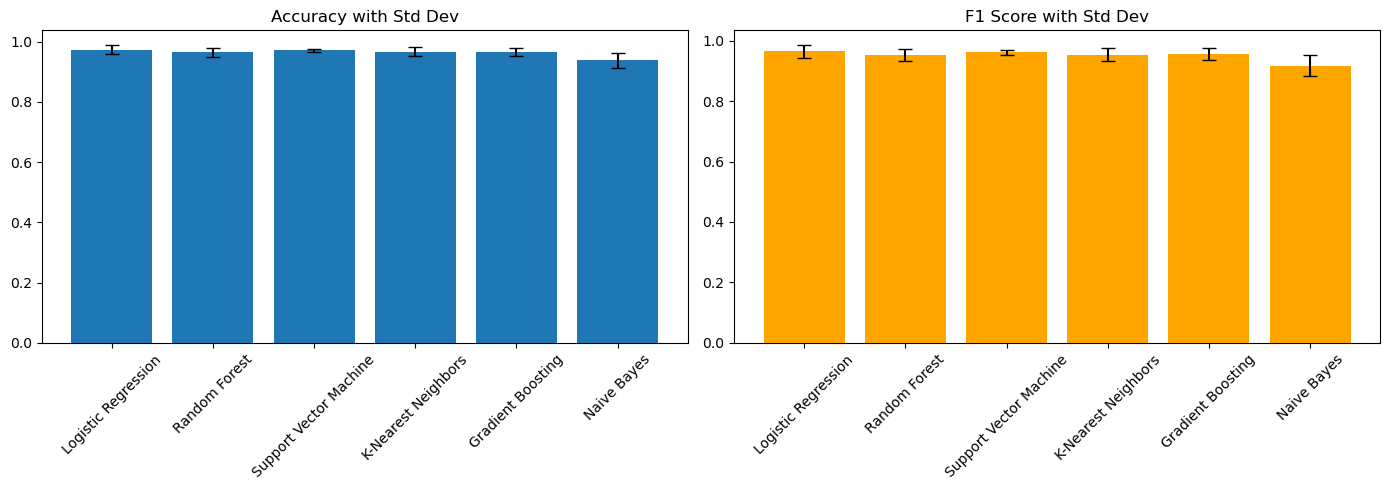

In [39]:
acc_scores = [results[model]['accuracy']['mean'] for model in models]
acc_std = [results[model]['accuracy']['std'] for model in models]

f1_scores = [results[model]['f1']['mean'] for model in models]
f1_std = [results[model]['f1']['std'] for model in models]

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(models.keys(), acc_scores, yerr=acc_std, capsize=5)
ax[0].set_title("Accuracy with Std Dev")
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar(models.keys(), f1_scores, yerr=f1_std, capsize=5, color='orange')
ax[1].set_title("F1 Score with Std Dev")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Model Optimization & Comparison

#### Setup

In [41]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc

#### Hyperparameter Tuning for Each Model

In [43]:
#Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

log_reg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_log_reg = GridSearchCV(
    log_reg, log_reg_params, cv=5, scoring='roc_auc', n_jobs=-1
)
grid_log_reg.fit(X_train, y_train)

print("Best Logistic Regression Params:", grid_log_reg.best_params_)
print("Best AUC:", grid_log_reg.best_score_)


Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best AUC: 0.9958720330237358


In [45]:
#Random Forest
rf = RandomForestClassifier(random_state=42)

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_rf = RandomizedSearchCV(
    rf, rf_params, cv=5, n_iter=20, scoring='roc_auc', n_jobs=-1, random_state=42
)
random_rf.fit(X_train, y_train)

print("Best Random Forest Params:", random_rf.best_params_)
print("Best AUC:", random_rf.best_score_)

Best Random Forest Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'bootstrap': False}
Best AUC: 0.9905056759545923


In [47]:
#Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)

gb_params = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    
    'subsample': [0.8, 1.0]
}

random_gb = RandomizedSearchCV(
    gb, gb_params, cv=5, n_iter=20, scoring='roc_auc', n_jobs=-1, random_state=42
)
random_gb.fit(X_train, y_train)

print("Best Gradient Boosting Params:", random_gb.best_params_)
print("Best AUC:", random_gb.best_score_)

Best Gradient Boosting Params: {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.05}
Best AUC: 0.9907636738906088


In [49]:
#Support Vector Machine (SVC)
from sklearn.svm import SVC

svc = SVC(probability=True, random_state=42)

svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svc = GridSearchCV(
    svc, svc_params, cv=5, scoring='roc_auc', n_jobs=-1
)
grid_svc.fit(X_train, y_train)

print("Best SVM Params:", grid_svc.best_params_)
print("Best AUC:", grid_svc.best_score_)

Best SVM Params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best AUC: 0.9947368421052631


In [51]:
#K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(
    knn, knn_params, cv=5, scoring='roc_auc', n_jobs=-1
)
grid_knn.fit(X_train, y_train)

print("Best KNN Params:", grid_knn.best_params_)
print("Best AUC:", grid_knn.best_score_)

Best KNN Params: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best AUC: 0.9911764705882353


In [53]:
#Naive Bayes (No hyperparameters to tune)
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

y_prob_nb = nb.predict_proba(X_test)[:, 1]
y_pred_nb = nb.predict(X_test)

print("\n==== Naive Bayes ====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Test ROC AUC:", roc_auc_score(y_test, y_prob_nb))


==== Naive Bayes ====
Confusion Matrix:
 [[69  3]
 [ 6 36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        72
           1       0.92      0.86      0.89        42

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114

Test ROC AUC: 0.9890873015873015


## Final Comparison on Test Set

In [55]:
# Store best estimators
best_models = {
    "Logistic Regression": grid_log_reg.best_estimator_,
    "Random Forest": random_rf.best_estimator_,
    "Gradient Boosting": random_gb.best_estimator_,
    "SVM": grid_svc.best_estimator_,
    "KNN": grid_knn.best_estimator_,
    "Naive Bayes": nb
}
# Evaluate all
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    # Check predict_proba support
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        # Use decision_function if available (e.g., SVM)
        y_prob = model.decision_function(X_test)
    
    print(f"\n==== {name} ====")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Test ROC AUC:", roc_auc_score(y_test, y_prob))



==== Logistic Regression ====
Confusion Matrix:
 [[71  1]
 [ 2 40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Test ROC AUC: 0.9857804232804233

==== Random Forest ====
Confusion Matrix:
 [[72  0]
 [ 4 38]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114

Test ROC AUC: 0.9910714285714286

==== Gradient Boosting ====
Confusion Matrix:
 [[72  0]
 [ 3 39]]
Classification Report:
          

## Optional - ROC Curve Visualization

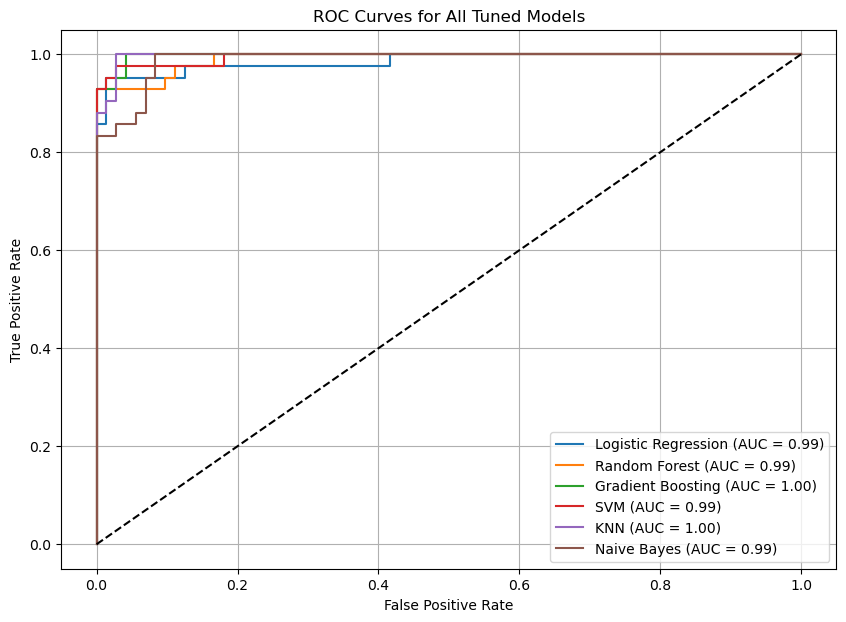

In [57]:
plt.figure(figsize=(10, 7))

for name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for All Tuned Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

## Install & Import SHAP

In [59]:
!pip install lime --quiet

In [61]:
import lime
import lime.lime_tabular

In [63]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = X_train,  # No .values here
    feature_names = X.columns.tolist(),  # This still assumes X is a DataFrame
    class_names = ['Benign', 'Malignant'],
    mode = 'classification'
)

In [65]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [67]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=['Benign', 'Malignant'],
    mode='classification'
)

In [69]:
# Pick an instance to explain (e.g., first test sample)
i = 0
sample = X_test.iloc[i].values.reshape(1, -1)

# Explain prediction
exp = explainer.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=model.predict_proba
)

# Visualize
exp.show_in_notebook(show_table=True)


In [71]:
# Save explanation to HTML file
exp.save_to_file('lime_explanation.html')

## Interpretation and Model Selection (with LIME)

#### Quantitative Evaluation of All Models 

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Support Vector Machine
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC(probability=True, random_state=42)

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. Initialize all models
models = {
    "Logistic Regression":      LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest":            RandomForestClassifier(random_state=42),
    "Support Vector Machine":   SVC(probability=True, random_state=42),
    "K-Nearest Neighbors":      KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting":        GradientBoostingClassifier(random_state=42),
    "Naive Bayes":              GaussianNB()
}

# 2. Fit each model
for name, model in models.items():
    model.fit(X_train, y_train)

# 3. Evaluate each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    # use predict_proba for AUC if available, else decision_function
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)
    
    print(f"\n{name}:")
    print("Accuracy: ", round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", round(precision_score(y_test, y_pred), 4))
    print("Recall:   ", round(recall_score(y_test, y_pred), 4))
    print("F1 Score: ", round(f1_score(y_test, y_pred), 4))
    print("AUC-ROC:  ", round(roc_auc_score(y_test, y_score), 4))


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression:
Accuracy:  0.9474
Precision: 0.9737
Recall:    0.881
F1 Score:  0.925
AUC-ROC:   0.9921

Random Forest:
Accuracy:  0.9737
Precision: 1.0
Recall:    0.9286
F1 Score:  0.963
AUC-ROC:   0.9929

Support Vector Machine:
Accuracy:  0.9035
Precision: 1.0
Recall:    0.7381
F1 Score:  0.8493
AUC-ROC:   0.9808

K-Nearest Neighbors:
Accuracy:  0.9123
Precision: 0.9706
Recall:    0.7857
F1 Score:  0.8684
AUC-ROC:   0.9547

Gradient Boosting:
Accuracy:  0.9649
Precision: 1.0
Recall:    0.9048
F1 Score:  0.95
AUC-ROC:   0.9947

Naive Bayes:
Accuracy:  0.9386
Precision: 1.0
Recall:    0.8333
F1 Score:  0.9091
AUC-ROC:   0.9934


In [77]:
#evaluation block
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize all models
logreg = LogisticRegression(max_iter=1000, random_state=42)
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(probability=True, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)
gb_model = GradientBoostingClassifier(random_state=42)
nb_model = GaussianNB()

# Train all models
logreg.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)

# Dictionary of models
models = {
    "Logistic Regression": logreg,
    "Random Forest": rf_model,
    "Support Vector Machine": svm_model,
    "K-Nearest Neighbors": knn_model,
    "Gradient Boosting": gb_model,
    "Naive Bayes": nb_model
}

# Evaluate each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    print(f"\n{name}:")
    print("Accuracy: ", round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", round(precision_score(y_test, y_pred), 4))
    print("Recall:   ", round(recall_score(y_test, y_pred), 4))
    print("F1 Score: ", round(f1_score(y_test, y_pred), 4))
    print("AUC-ROC:  ", round(roc_auc_score(y_test, y_proba), 4))


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression:
Accuracy:  0.9474
Precision: 0.9737
Recall:    0.881
F1 Score:  0.925
AUC-ROC:   0.9921

Random Forest:
Accuracy:  0.9737
Precision: 1.0
Recall:    0.9286
F1 Score:  0.963
AUC-ROC:   0.9929

Support Vector Machine:
Accuracy:  0.9035
Precision: 1.0
Recall:    0.7381
F1 Score:  0.8493
AUC-ROC:   0.9808

K-Nearest Neighbors:
Accuracy:  0.9123
Precision: 0.9706
Recall:    0.7857
F1 Score:  0.8684
AUC-ROC:   0.9547

Gradient Boosting:
Accuracy:  0.9649
Precision: 1.0
Recall:    0.9048
F1 Score:  0.95
AUC-ROC:   0.9947

Naive Bayes:
Accuracy:  0.9386
Precision: 1.0
Recall:    0.8333
F1 Score:  0.9091
AUC-ROC:   0.9934


| Model                  | Accuracy | Precision | Recall | F1 Score | AUC-ROC |
| ---------------------- | -------- | --------- | ------ | -------- | ------- |
| Logistic Regression    | 0.9474   | 0.9737    | 0.8810 | 0.9250   | 0.9921  |
| Random Forest          | 0.9737   | 1.0000    | 0.9286 | 0.9630   | 0.9929  |
| Support Vector Machine | 0.9035   | 1.0000    | 0.7381 | 0.8493   | 0.9808  |
| KNN                    | 0.9123   | 0.9706    | 0.7857 | 0.8684   | 0.9547  |
| Gradient Boosting      | 0.9649   | 1.0000    | 0.9048 | 0.9500   | 0.9947  |
| Naive Bayes            | 0.9386   | 1.0000    | 0.8333 | 0.9091   | 0.9934  |


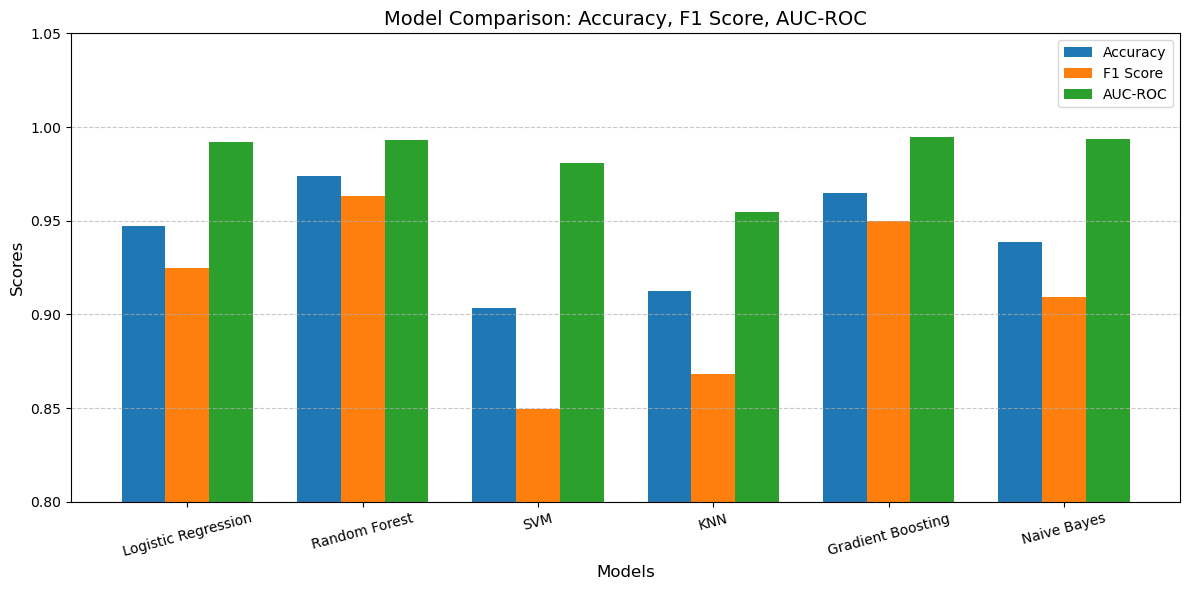

In [79]:
#visualization
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "Logistic Regression",
    "Random Forest",
    "SVM",
    "KNN",
    "Gradient Boosting",
    "Naive Bayes"
]

# Metrics
accuracy = [0.9474, 0.9737, 0.9035, 0.9123, 0.9649, 0.9386]
f1_score = [0.925, 0.963, 0.8493, 0.8684, 0.95, 0.9091]
roc_auc = [0.9921, 0.9929, 0.9808, 0.9547, 0.9947, 0.9934]

# Set bar width and position
bar_width = 0.25
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(r1, accuracy, width=bar_width, label='Accuracy')
plt.bar(r2, f1_score, width=bar_width, label='F1 Score')
plt.bar(r3, roc_auc, width=bar_width, label='AUC-ROC')

# Formatting
plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Model Comparison: Accuracy, F1 Score, AUC-ROC', fontsize=14)
plt.xticks([r + bar_width for r in range(len(models))], models, rotation=15)
plt.ylim(0.8, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


In [81]:
#hyperparameter tuning for model development
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)
print("Best RF Parameters:", rf_grid.best_params_)

# Predict with best model
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best RF Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}


In [83]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10]
}

gb_random = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=gb_params,
    n_iter=20,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

gb_random.fit(X_train, y_train)
print("Best GB Parameters:", gb_random.best_params_)

# Predict with best model
gb_best = gb_random.best_estimator_
y_pred_gb = gb_best.predict(X_test)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best GB Parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 5, 'learning_rate': 0.2}


## Updated Evaluation with Tuned Models

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluate the tuned models
tuned_models = {
    "Tuned Random Forest": rf_best,
    "Tuned Gradient Boosting": gb_best
}

for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n{name}:")
    print("Accuracy: ", round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", round(precision_score(y_test, y_pred), 4))
    print("Recall:   ", round(recall_score(y_test, y_pred), 4))
    print("F1 Score: ", round(f1_score(y_test, y_pred), 4))
    print("AUC-ROC:  ", round(roc_auc_score(y_test, y_prob), 4))


Tuned Random Forest:
Accuracy:  0.9737
Precision: 1.0
Recall:    0.9286
F1 Score:  0.963
AUC-ROC:   0.9929

Tuned Gradient Boosting:
Accuracy:  0.9649
Precision: 1.0
Recall:    0.9048
F1 Score:  0.95
AUC-ROC:   0.9974


#### after hyperparameter tuning, the plots

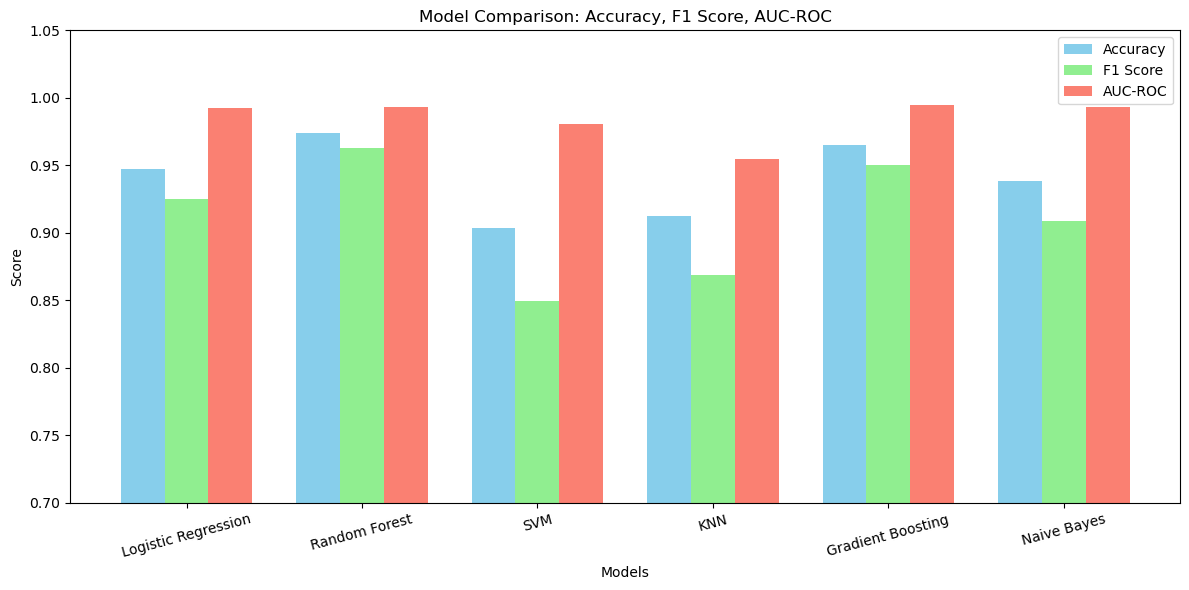

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Updated metrics with all 6 models
models = [
    "Logistic Regression", "Random Forest", "SVM",
    "KNN", "Gradient Boosting", "Naive Bayes"
]

accuracy = [0.9474, 0.9737, 0.9035, 0.9123, 0.9649, 0.9386]
f1_scores = [0.925, 0.963, 0.8493, 0.8684, 0.95, 0.9091]
auc_roc = [0.9921, 0.9929, 0.9808, 0.9547, 0.9947, 0.9934]

x = np.arange(len(models))
width = 0.25

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(x - width, accuracy, width, label='Accuracy', color='skyblue')
plt.bar(x, f1_scores, width, label='F1 Score', color='lightgreen')
plt.bar(x + width, auc_roc, width, label='AUC-ROC', color='salmon')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Comparison: Accuracy, F1 Score, AUC-ROC')
plt.xticks(x, models, rotation=15)
plt.ylim(0.7, 1.05)
plt.legend()
plt.tight_layout()

plt.show()


In [93]:
# FINAL CELL: SAVE UNIVARIATE HISTOGRAMS WITH CORRECT COLUMN NAMES
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure the output directory exists
os.makedirs("figures", exist_ok=True)

def save_fig(name, dpi=300):
    plt.tight_layout()
    plt.savefig(f"figures/{name}.png", dpi=dpi)
    plt.close()

# Use your real column names for the “mean” features (suffix “1”)
features = ['radius1', 'texture1', 'area1']

for feat in features:
    plt.figure(figsize=(6,4))
    sns.histplot(
        data=df,
        x=feat,           # matches df.columns exactly
        hue='diagnosis',  # ensure this column is present
        kde=True,
        element='step'
    )
    plt.title(f'{feat} Distribution by Diagnosis')
    # save as e.g. radius1_distribution.png
    save_fig(f'{feat}_distribution')


In [91]:
# Show exactly what columns you have
print(df.columns.tolist())


['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3', 'diagnosis']


In [95]:
import os

# 1) Print current working directory
cwd = os.getcwd()
print("Current working directory:", cwd, "\n")


Current working directory: C:\Users\ASUS\Breast Cancer 



In [97]:
import os
def save_fig(name, dpi=300):
    os.makedirs("figures", exist_ok=True)
    plt.tight_layout()
    plt.savefig(f"figures/{name}.png", dpi=dpi)
    plt.close()

In [99]:
# Bivariate Scatter Plots
bivariate_pairs = [('radius1', 'texture1'), ('perimeter1', 'area1')]
for x, y in bivariate_pairs:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=x, y=y, hue='diagnosis', alpha=0.7)
    plt.title(f'{x} vs {y}')
    save_fig(f'{x}_{y}_scatter')

In [101]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(columns=['diagnosis']).corr(), cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Heatmap')
save_fig('correlation_heatmap')

In [103]:
models = ["Logistic Regression", "Random Forest", "SVM", "KNN", "Gradient Boosting", "Naive Bayes"]
accuracy = [0.9474, 0.9737, 0.9035, 0.9123, 0.9649, 0.9386]
f1_scores = [0.925, 0.963, 0.8493, 0.8684, 0.95, 0.9091]
roc_auc = [0.9921, 0.9929, 0.9808, 0.9547, 0.9947, 0.9934]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, accuracy, width, label='Accuracy')
plt.bar(x, f1_scores, width, label='F1 Score')
plt.bar(x + width, roc_auc, width, label='AUC-ROC')

plt.xticks(x, models, rotation=15)
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.ylim(0.8, 1.05)
plt.legend()
plt.grid(True)
save_fig('model_performance_comparison')


In [105]:
plt.figure(figsize=(8, 6))
for name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of All Models')
plt.legend()
plt.grid()
save_fig('roc_curves')


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarnin

In [109]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    save_fig(title.lower().replace(" ", "_"))

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, f'{name} Confusion Matrix')


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarnin

In [111]:
# Example for Gradient Boosting (gb_best)
importances = gb_best.feature_importances_
indices = np.argsort(importances)[::-1][:10]
top_features = [X.columns[i] for i in indices]

plt.figure(figsize=(8, 5))
sns.barplot(x=importances[indices], y=top_features)
plt.title('Top 10 Feature Importances - Gradient Boosting')
save_fig('gb_feature_importance')


In [113]:
# Assumes LIME explainer is already defined
exp = explainer.explain_instance(X_test.iloc[0], gb_best.predict_proba, num_features=10)
fig = exp.as_pyplot_figure()
save_fig('lime_explanation_sample1')


C:\Users\ASUS\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\ASUS\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\ASUS\anaconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 'area1'

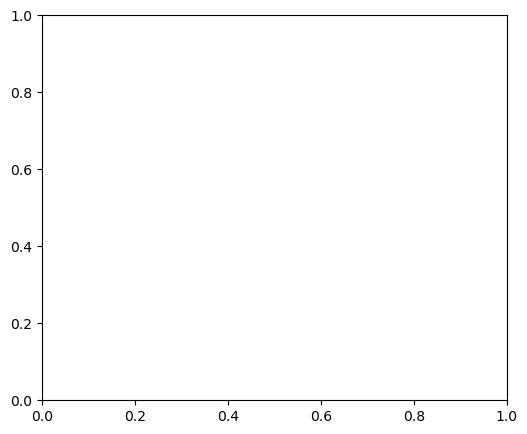

In [115]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plotting
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=y, cmap='coolwarm', alpha=0.7, edgecolor='k'
)
plt.title('2D PCA Scatter Plot')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)

# Save the figure
plt.tight_layout()
plt.savefig('figures/pca_scatter.png', dpi=300, bbox_inches='tight')
plt.close()


In [117]:
# Ensure y is diagnosis (encoded as 0/1), not a feature like 'area1'
if 'diagnosis' in df.columns:
    y = df['diagnosis']  # Make sure this is correct target column


In [119]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

# Ensure the directory exists
os.makedirs("figures", exist_ok=True)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# PCA Scatter Plot
plt.figure(figsize=(6, 5))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=y, cmap='coolwarm', alpha=0.7, edgecolor='k'
)
plt.title('2D PCA Scatter Plot')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)

# Save the plot
plt.tight_layout()
plt.savefig("figures/pca_scatter.png", dpi=300, bbox_inches='tight')
plt.close()


In [123]:
import shap
import matplotlib.pyplot as plt
import os

# Ensure directory exists
os.makedirs("figures", exist_ok=True)

# Create SHAP explainer for Gradient Boosting with additivity check disabled
explainer = shap.Explainer(gb_best, X_train)

# Compute SHAP values with additivity check OFF
shap_values = explainer(X_test, check_additivity=False)

# Save SHAP summary plot
plt.figure()
shap.plots.beeswarm(shap_values, show=False)
plt.title("SHAP Summary Plot (Gradient Boosting)")
plt.tight_layout()
plt.savefig("figures/shap_summary_plot.png", dpi=300, bbox_inches='tight')
plt.close()
